This notebook computes mutual information between replay triggers and downstream activity.

In [1]:
%reset -f
%matplotlib inline
from ast import literal_eval
from copy import deepcopy as copy
from itertools import product as cprod
import sys

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln


N_SEEDS = 10
MAX_SEED = 1000
DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5
RANK_CORR_CUTOFF = .9

MIN_N_REPLAY = 5

MI_D_SMLN = 150
MI_TRG_DT = 0.5
MI_DTCN_WDW = (.05, .25)
MI_X = -.75
MI_Y = .75
MI_R = .25
MI_FRAC = 0.9


# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 2000,
    'W_PC_PC': 0.028, 'L_PC_PC': 0.0615, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,  # unused
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .8},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# Plot dynamics regimes

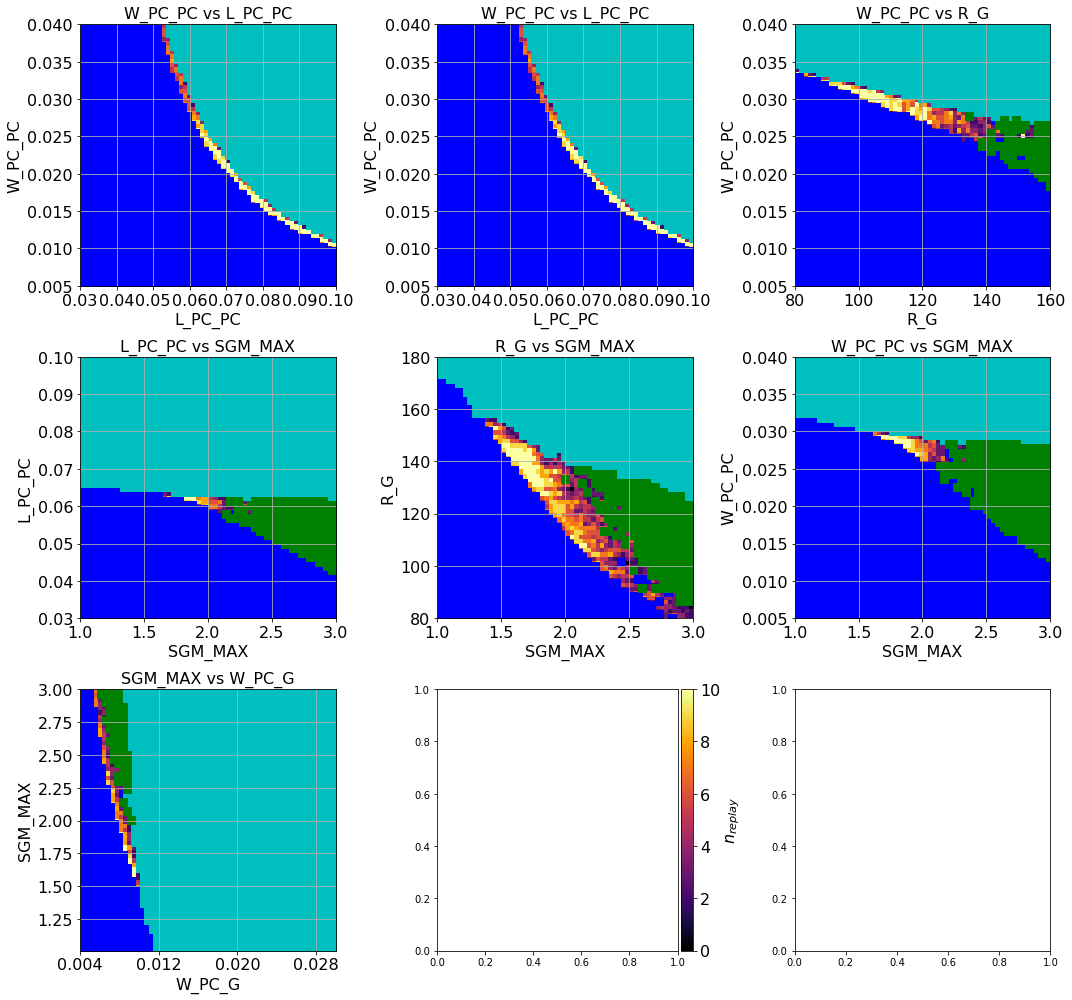

In [2]:
RSLT_FILES = [
    'dense_n_replay_param_sweep_L_PC_PC_W_PC_PC_0.csv',
    'dense_n_replay_param_sweep_L_PC_PC_W_PC_PC_1.csv',
    'dense_n_replay_param_sweep_R_G_W_PC_PC_0.csv',
    'dense_n_replay_param_sweep_SGM_MAX_L_PC_PC_0.csv',
    'dense_n_replay_param_sweep_SGM_MAX_R_G_0.csv',
    'dense_n_replay_param_sweep_SGM_MAX_W_PC_PC_0.csv',
    'dense_n_replay_param_sweep_W_PC_G_SGM_MAX_0.csv',
]

X_TICKS = [
    None, None, np.linspace(80, 160, 5), 
    np.linspace(1, 3, 5), np.linspace(1, 3, 5), np.linspace(1, 3, 5), 
    [.004, .012, .02, .028]
]

m_paramss = []
s_paramss = []
cols = []
dfs = []
x_lims = []
y_lims = []

fig, axs = plt.subplots(3, 3, figsize=(15, 14), tight_layout=True)

for rslt_file, ax, x_ticks in zip(RSLT_FILES, axs.flatten(), X_TICKS):
    
    with open(rslt_file, 'r') as f:
        m_params = literal_eval(f.readline().strip())
        s_params = literal_eval(f.readline().strip())

    df = pd.read_csv(rslt_file, header=2, index_col=0)

    col_x = df.columns[1]
    col_y = df.columns[2]
    
    vals_x = df[col_x]
    vals_y = df[col_y]
    
    n_replay = df['N_REPLAY']
    
    im = ax.scatter(vals_x, vals_y, marker='s', s=55, c=n_replay, cmap='inferno', vmin=0, vmax=10, lw=0, zorder=0)
    
    # color non-replay units by fadeout vs blowup vs disordered
    df_fadeout = df[(n_replay < 2) & (df['N_FADEOUT'] > df['N_BLOWUP']) & (df['N_FADEOUT'] > df['N_DISORDERED'])]
    ax.scatter(df_fadeout[col_x], df_fadeout[col_y], marker='s', s=55, c='b', zorder=1)
    
    df_blowup = df[(n_replay < 2) & (df['N_BLOWUP'] > df['N_FADEOUT']) & (df['N_BLOWUP'] > df['N_DISORDERED'])]
    ax.scatter(df_blowup[col_x], df_blowup[col_y], marker='s', s=55, c='c', zorder=1)
    
    df_disordered = df[(n_replay < 2) & (df['N_DISORDERED'] > df['N_BLOWUP']) & (df['N_DISORDERED'] > df['N_FADEOUT'])]
    ax.scatter(df_disordered[col_x], df_disordered[col_y], marker='s', s=55, c='g', zorder=1)
    
    x_lim = [vals_x.min(), vals_x.max()]
    y_lim = [vals_y.min(), vals_y.max()]
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title('{} vs {}'.format(col_y, col_x))
    
    ax.grid()
    
    set_font_size(ax, 16)
    
    m_paramss.append(m_params)
    s_paramss.append(s_params)
    
    cols.append((col_x, col_y))
    
    dfs.append(df)
    
    x_lims.append(x_lim)
    y_lims.append(y_lim)
    
# put colorbar on unused axis
divider = make_axes_locatable(axs[2, 1])
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax, ticks=[0, 2, 4, 6, 8, 10])
c_ax.set_ylabel('$n_{replay}$')

set_font_size(c_ax, 16)

# Plot mutual info

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log2
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log2
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log2
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log2


mi_min: 0.0
mi_max: 1.0


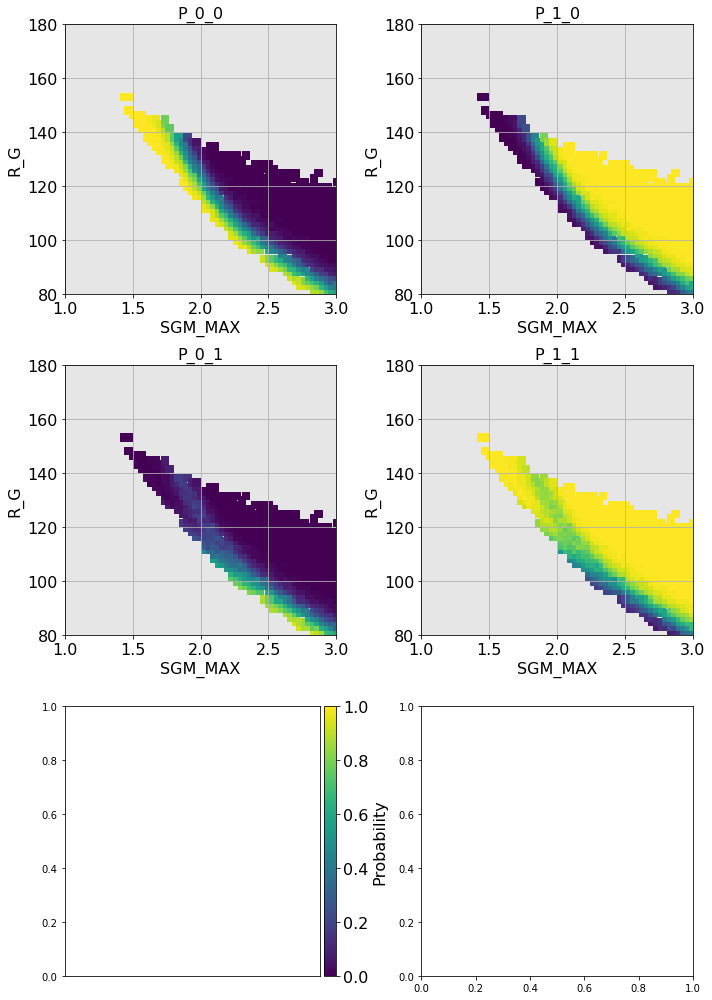

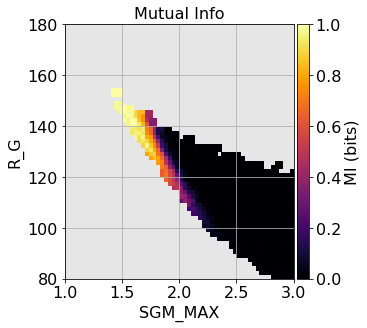

In [3]:
RSLT_FILE = 'mi_dense_n_replay_param_sweep_SGM_MAX_R_G_0.csv'

x_lim = x_lims[4]
y_lim = y_lims[4]

x_ticks = X_TICKS[4]

df = pd.read_csv(RSLT_FILE, header=2, index_col=0)
col_x = df.columns[0]
col_y = df.columns[1]

vals_x = df[col_x]
vals_y = df[col_y]

p_0_0 = df['P_0_0']  # prob(no trj-end spks | no trg)
p_1_0 = df['P_1_0']  # prob(trj-end spks | no trg)
p_0_1 = df['P_0_1']  # prob(no trj-end spks | trg)
p_1_1 = df['P_1_1']  # prob(trj-end spks | trg)

# plot probabilities
fig, axs = plt.subplots(3, 2, figsize=(10, 14), tight_layout=True)

for p_x_y, ax in zip(['P_0_0', 'P_1_0', 'P_0_1', 'P_1_1'], axs.flatten()):
    
    im = ax.scatter(vals_x, vals_y, c=df[p_x_y], vmin=0, vmax=1, s=55, marker='s')
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    ax.set_xticks(x_ticks)
    
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    
    ax.set_title(p_x_y)
    ax.set_facecolor((.9, .9, .9))
    ax.grid()
    
    set_font_size(ax, 16)
    
# add colorbar on unused axis
divider = make_axes_locatable(axs[2, 0])
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax)
c_ax.set_ylabel('Probability')
set_font_size(c_ax, 16)

axs[2, 0].xaxis.set_visible(False)
    
# plot mutual info
## define quantities
p_0_0 = df['P_0_0']  # prob(no trj-end spks | no trg)
p_1_0 = df['P_1_0']  # prob(trj-end spks | no trg)
p_0_1 = df['P_0_1']  # prob(no trj-end spks | trg)
p_1_1 = df['P_1_1']  # prob(trj-end spks | trg)

assert np.all(np.isclose(p_0_0 + p_1_0, 1))
assert np.all(np.isclose(p_0_1 + p_1_1, 1))

p_y_0 = 0.5  # prob(no trg)
p_y_1 = 0.5  # prob(trg)

p_x_0 = p_0_0*p_y_0 + p_0_1*p_y_1  # prob(no trj-end spks)
p_x_1 = p_1_0*p_y_0 + p_1_1*p_y_1  # prob(trj-end spks)

assert np.all(np.isclose(p_x_0 + p_x_1, 1))

# terms for entropy/MI
## response entropy (H[X])
log_p_x_0 = np.log2(p_x_0)
log_p_x_0[p_x_0 == 0] = 0.  # correct for 0 * Inf

log_p_x_1 = np.log2(p_x_1)
log_p_x_1[p_x_1 == 0] = 0.

## noise entropy given no trg (H[X|y=0])
log_p_0_0 = np.log2(p_0_0)
log_p_0_0[p_0_0 == 0] = 0.

log_p_1_0 = np.log2(p_1_0)
log_p_1_0[p_1_0 == 0] = 0.

## noise entropy given trg (H[X|y=1])
log_p_0_1 = np.log2(p_0_1)
log_p_0_1[p_0_1 == 0] = 0.

log_p_1_1 = np.log2(p_1_1)
log_p_1_1[p_1_1 == 0] = 0.

# compute entropies
## response entropy
h_x = -(p_x_0*log_p_x_0 + p_x_1*log_p_x_1)  # entropy(trj-end spks, no trj-end spks)

## noise entropy given no trg
h_x_0 = -(p_0_0*log_p_0_0 + p_1_0*log_p_1_0)

## noise entropy given trg
h_x_1 = -(p_0_1*log_p_0_1 + p_1_1*log_p_1_1)

## expected noise entropy
h_x_noise = h_x_0*p_y_0 + h_x_1*p_y_1

## mi 
mi_x_y = h_x - h_x_noise

# plot
fig, ax = plt.subplots(1, 1, figsize=(5.2, 14/3), tight_layout=True)
mi_min = mi_x_y.min()
mi_max = mi_x_y.max()

im = ax.scatter(vals_x, vals_y, c=mi_x_y, cmap='inferno', vmin=mi_min, vmax=mi_max, marker='s', s=55)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.set_xticks(x_ticks)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title('Mutual Info')

ax.set_facecolor((.9, .9, .9))
ax.grid()

set_font_size(ax, 16)

# add colorbar
divider = make_axes_locatable(ax)
c_ax = divider.append_axes('right', '5%', pad=0.05)
cb = fig.colorbar(im, cax=c_ax)
c_ax.set_ylabel('MI (bits)')

set_font_size(c_ax, 16)

print('mi_min:', mi_min)
print('mi_max:', mi_max)

## Define fadeout, blowup, disordered, and replay detection functions

In [5]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # check if fadeout or blowup
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    
    # check if replay is ordered or not
    ## get mask over spking trj cells
    trj_spk_mask = trj_mask & (rslt.spks[t_mask].sum(0) > 0.5)
    
    ## order nrns by place field location along trj
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    ### negative b/c trj is triggered to replay in reverse
    pf_order = -smln.dist_to_trj(pfxs[trj_spk_mask], pfys[trj_spk_mask], rslt.trj['x'], rslt.trj['y'])[1]
    
    ## order nrns by first spk times
    spk_order = rslt.spks[t_mask][:, trj_spk_mask].argmax(0)
    
    ## get correlation
    pf_spk_rank_corr = stats.spearmanr(pf_order, spk_order)[0]
    
    if pf_spk_rank_corr < RANK_CORR_CUTOFF:
        return 'disordered'
    else:
        return 'replay'

## Define mutual info evaluation function

In [6]:
def get_p_mi(rslt, m_params, s_params):
    """
    Get probabilities needed to calc MI btwn replay trigger and trj-end spks.
    
    In return vals, p_1_0 refers to prob trj-end spks given no trigger.
    """

    # get trj-end mask (nrns w/ PFs at end of trj)
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    pfxs = rslt.ntwk.pfxs
    pfys = rslt.ntwk.pfys
    
    dxs = pfxs - MI_X
    dys = pfys - MI_Y
    d_to_trj_end = np.sqrt(dxs**2 + dys**2)
    
    trj_end_pcs = mask_pc & (d_to_trj_end <= MI_R)
    
    # get spks from trj end
    trj_end_spks = rslt.spks[:, trj_end_pcs]
    
    # loop over all trigger times and calc prob of trj-end spks
    trj_end_spk_trg = []
    
    for t_trg in np.arange(MI_TRG_DT, s_params['schedule']['D_SMLN'], MI_TRG_DT):
        
        # get t-mask over detection wdw
        start = t_trg + MI_DTCN_WDW[0]
        end = t_trg + MI_DTCN_WDW[1]
        
        t_mask = (start <= rslt.ts) & (rslt.ts < end)
        
        # get frac of trj_end nrns spking in detection wdw
        trj_end_pcs_spking = trj_end_spks[t_mask].sum(0) > .5
        frac_spking = np.sum(trj_end_pcs_spking) / trj_end_pcs.sum()
        
        if frac_spking > MI_FRAC:
            trj_end_spk_trg.append(True)
        else:
            trj_end_spk_trg.append(False)
            
    # prob. of no trj-end activation given trigger
    p_0_1 = 1 - np.mean(trj_end_spk_trg)
    # prob. of trj-end activation given trigger
    p_1_1 = np.mean(trj_end_spk_trg)
    
    
    # loop over all non-trigger times
    trj_end_spk_no_trg = []
    offset = MI_TRG_DT/2
    
    for t_trg in (np.arange(offset, s_params['schedule']['D_SMLN'], MI_TRG_DT)):
        
        # get t-mask over detection wdw
        start = t_trg + MI_DTCN_WDW[0]
        end = t_trg + MI_DTCN_WDW[1]
        
        t_mask = (start <= rslt.ts) & (rslt.ts < end)
        
        # get frac of trj_end nrns spking in detection wdw
        trj_end_pcs_spking = trj_end_spks[t_mask].sum(0) > .5
        frac_spking = np.sum(trj_end_pcs_spking) / trj_end_pcs.sum()
        
        if frac_spking > MI_FRAC:
            trj_end_spk_no_trg.append(True)
        else:
            trj_end_spk_no_trg.append(False)
            
    # prob. of no trj-end activation given no trigger
    p_0_0 = 1 - np.mean(trj_end_spk_no_trg)
    # prob. of trj-end activation given no trigger
    p_1_0 = np.mean(trj_end_spk_no_trg)
    
    return {'p_0_1': p_0_1, 'p_1_1': p_1_1, 'p_0_0': p_0_0, 'p_1_0': p_1_0}

## Test MI function

### No MI in fadeout

Running smln...
Smln complete.
RSP TYPE:  fadeout
MI_INFO:  {'p_0_0': 1.0, 'p_1_1': 0.0, 'p_1_0': 0.0, 'p_0_1': 1.0}


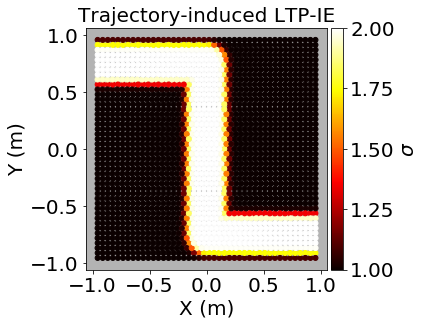

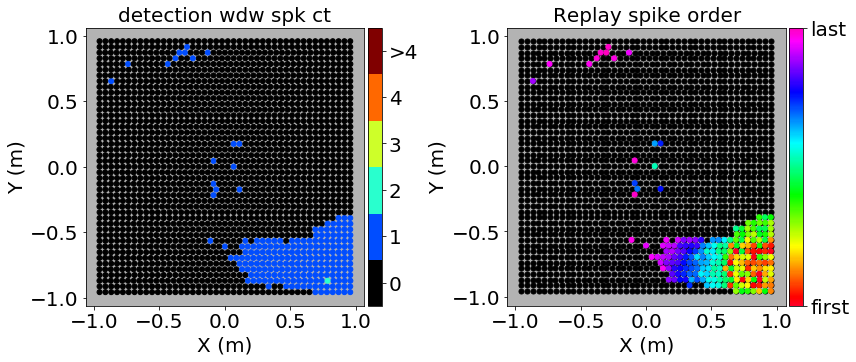

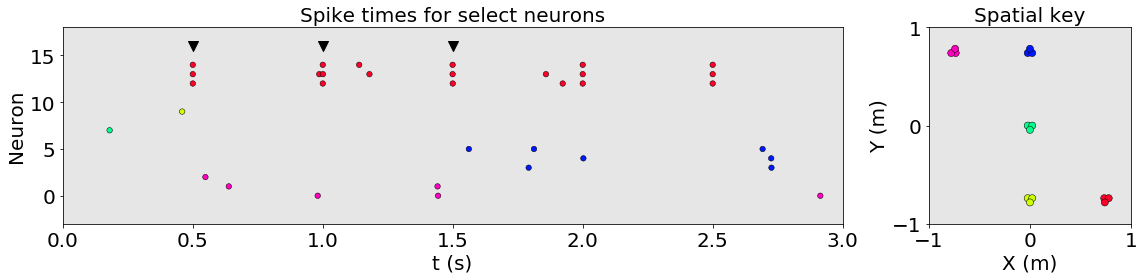

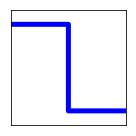

In [7]:
np.random.seed(0)

def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .023
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['schedule']['D_SMLN'] = 3
    
    # add in example triggers
    s_params['TRG'] = [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch=(0, 3),
        trg_plt=[(16, 'v'), (16, 'v'), (16, 'v')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('MI_INFO: ', get_p_mi(rslt, m_params, s_params))

test()

# expectation: p_0_0 and p_0_1 large, p_1_0 and p_1_1 small

### No MI in blowup

Running smln...
Smln complete.
RSP TYPE:  blowup
MI_INFO:  {'p_0_0': 0.33333333333333337, 'p_1_1': 1.0, 'p_1_0': 0.6666666666666666, 'p_0_1': 0.0}


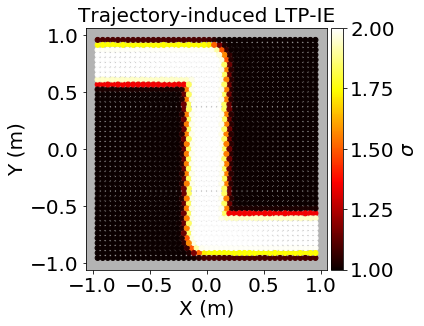

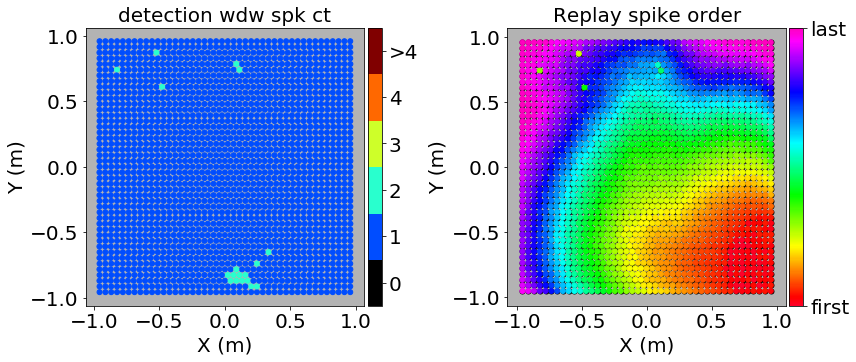

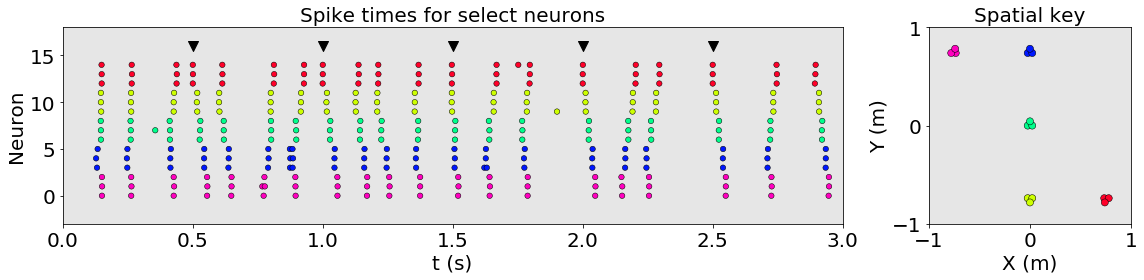

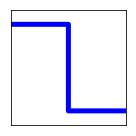

In [8]:
np.random.seed(0)

def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .04
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 0  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['schedule']['D_SMLN'] = 3
    
    # add in example triggers
    s_params['TRG'] = [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch=(0, 3),
        trg_plt=5*[(16, 'v')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('MI_INFO: ', get_p_mi(rslt, m_params, s_params))

test()

# expectation: p_1_0 and p_1_1 large, p_0_0, p_0_1 small

### MI in replay

Running smln...
Smln complete.
RSP TYPE:  replay
MI_INFO:  {'p_0_0': 0.5, 'p_1_1': 0.8, 'p_1_0': 0.5, 'p_0_1': 0.19999999999999996}


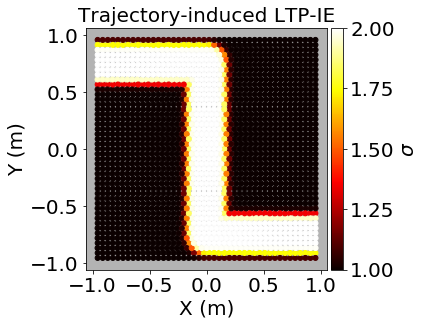

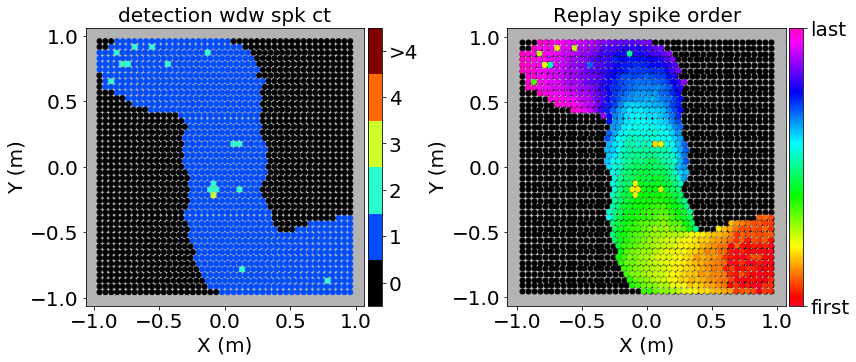

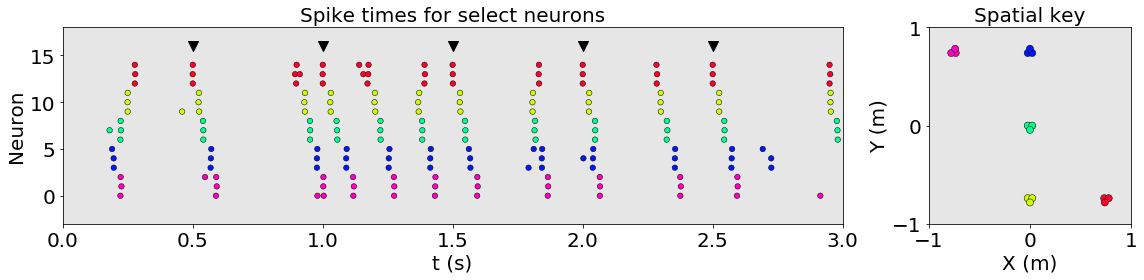

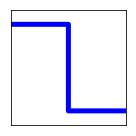

In [10]:
np.random.seed(0)

def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .028
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]
    s_params['schedule']['D_SMLN'] = 3
    
    # add in example triggers
    s_params['TRG'] = [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 1.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.0, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
        {'T': 2.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch=(0, 3),
        trg_plt=5*[(16, 'v')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))
    print('MI_INFO: ', get_p_mi(rslt, m_params, s_params))

test()

# expectation: p_0_0 and p_1_1 large, p_0_1 and p_1_0 small

# Param sweep

In [11]:
DYNAMICS_FILE = 'dense_n_replay_param_sweep_SGM_MAX_R_G_0.csv'
SAVE_FILE = 'mi_{}'.format(DYNAMICS_FILE)

PRINT_EVERY = 50

print('Running mi probabilities measurement smlns for file:', DYNAMICS_FILE, '\n')

# get params
with open (DYNAMICS_FILE, 'r') as f:

    # get params
    m_params = literal_eval(f.readline().strip())
    s_params = literal_eval(f.readline().strip())
    
# update smln dur for spontaneous activity measurement
s_params['schedule']['D_SMLN'] = MI_D_SMLN

# set triggers
trg_base = s_params['TRG'][0]

s_params['TRG'] = []

for t_trg in np.arange(MI_TRG_DT, MI_D_SMLN, MI_TRG_DT):
    trg = copy(trg_base)
    trg['T'] = t_trg
    s_params['TRG'].append(trg)

# get data
df_load = pd.read_csv(DYNAMICS_FILE, header=2, index_col=0)

col_x = df_load.columns[1]
col_y = df_load.columns[2]

# set up save DF and save file
DF_COLS = ['SMLN_ID', col_x, col_y, 'P_0_0', 'P_1_0', 'P_0_1', 'P_1_1', 'SEED']

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(m_params, s_params))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

# get mask over which smlns to repeat w/ speed measurements
repeat_mask = ((df_load['N_REPLAY'] + df_load['N_DISORDERED']) > MIN_N_REPLAY) & (df_load['N_BLOWUP'] == 0) & (df_load['SGM_MAX'] > 1)

n_trials = np.sum(repeat_mask)

# loop over repeats
np.random.seed(0)

for tr_ctr, (idx, row) in enumerate(df_load[repeat_mask].iterrows()):

    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')

    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, col_x: row[col_x], col_y: row[col_y]}

    # use model params from this row
    m_params_ = copy(m_params)
    m_params_[col_x] = row[col_x]
    m_params_[col_y] = row[col_y]

    # set rng seed
    s_params['RNG_SEED'] = np.random.randint(MAX_SEED)

    # run smln
    rslt = smln.run(m_params_, s_params)

    # save mi probabilities and rng seed
    for k, v in get_p_mi(rslt, m_params_, s_params).items():
        save_dict[k.upper()] = v

    save_dict['SEED'] = s_params['RNG_SEED']

    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)

    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)

Running mi probabilities measurement smlns for file: dense_n_replay_param_sweep_SGM_MAX_R_G_0.csv 


Running trial 1/738
..................................................
Running trial 51/738
..................................................
Running trial 101/738
..................................................
Running trial 151/738
..................................................
Running trial 201/738
..................................................
Running trial 251/738
..................................................
Running trial 301/738
..................................................
Running trial 351/738
..................................................
Running trial 401/738
..................................................
Running trial 451/738
..................................................
Running trial 501/738
..................................................
Running trial 551/738
..................................................
Running trial 601/738
....